couldn't import doomish
Couldn't import doom
(288, 512, 3)
(288, 512)


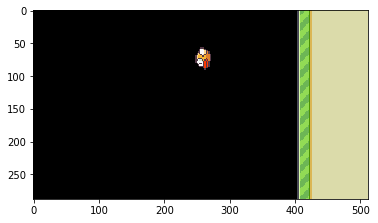

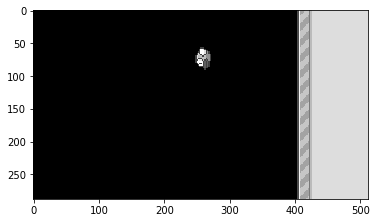

In [1]:
# import package needed
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy" # make window not appear
import tensorflow as tf
import numpy as np
import math
import skimage.color
import skimage.transform
from ple.games.flappybird import FlappyBird
from ple import PLE
from myUtil import make_anim
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False) # environment interface to game
env.reset_game()
env.act(0) # dummy input to get screen correct

# get rgb screen
screen = env.getScreenRGB()
plt.imshow(screen)
print(screen.shape)

# get grayscale screen
plt.figure()
screen = env.getScreenGrayscale()
plt.imshow(screen, cmap='gray')
print(screen.shape)

In [2]:
# define input size
screen_width = 80
screen_height = 80
num_stack = 4

In [3]:
class Actor_critic:
    def __init__(self, name, num_action, discount_factor=0.99):
        self.exploring_rate = 0.1
        self.discount_factor = discount_factor
        self.num_action = num_action
        self.name = name
        with tf.variable_scope(name):
            self.build_model()
            
        self.chpt_path = './checkpoints'
        self.saver = tf.train.Saver(max_to_keep=20)

    def build_model(self):
        # input: current screen, selected action and reward
        self.input_screen = tf.placeholder(
            tf.float32, shape=[None, screen_width, screen_height, num_stack])
        self.action = tf.placeholder(tf.int32, [None])
        self.reward = tf.placeholder(tf.float32, [None])
        self.is_training = tf.placeholder(tf.bool, shape=[])

        def value_net(screen, reuse=False):
            with tf.variable_scope(
                    "value_net",
                    reuse=reuse,
                    initializer=tf.truncated_normal_initializer(stddev=1e-2)):
                conv1 = tf.layers.conv2d(
                    inputs=screen,
                    filters=32,
                    kernel_size=[8, 8],
                    strides=[4, 4],
                    padding='SAME',
                    activation=tf.nn.relu)
                pool1 = tf.layers.max_pooling2d(
                    conv1, pool_size=[2, 2], strides=[2, 2], padding='SAME')

                conv2 = tf.layers.conv2d(
                    inputs=pool1,
                    filters=64,
                    kernel_size=[4, 4],
                    strides=[2, 2],
                    padding='SAME',
                    activation=tf.nn.relu)
                conv3 = tf.layers.conv2d(
                    inputs=conv2,
                    filters=64,
                    kernel_size=[3, 3],
                    strides=[1, 1],
                    padding='SAME',
                    activation=tf.nn.relu)
                flat = tf.contrib.layers.flatten(conv3)
                dense = tf.layers.dense(
                    inputs=flat, units=512, activation=tf.nn.relu)
                V = tf.layers.dense(inputs=dense, units=1, activation=None)
                return V

        def policy_net(screen, reuse=False):
            with tf.variable_scope("policy_net", reuse=reuse):
                conv1 = tf.layers.conv2d(
                    inputs=screen,
                    filters=32,
                    kernel_size=[8, 8],
                    strides=[4, 4],
                    padding='SAME',
                    activation=tf.nn.relu)
                pool1 = tf.layers.max_pooling2d(
                    conv1, pool_size=[2, 2], strides=[2, 2], padding='SAME')

                conv2 = tf.layers.conv2d(
                    inputs=pool1,
                    filters=64,
                    kernel_size=[4, 4],
                    strides=[2, 2],
                    padding='SAME',
                    activation=tf.nn.relu)
                conv3 = tf.layers.conv2d(
                    inputs=conv2,
                    filters=64,
                    kernel_size=[3, 3],
                    strides=[1, 1],
                    padding='SAME',
                    activation=tf.nn.relu)
                self.flat = tf.contrib.layers.flatten(conv3)

                self.dense1 = tf.layers.dense(
                    inputs=self.flat, units=512, activation=tf.nn.relu)
                self.dense2 = tf.layers.dense(
                    inputs=self.dense1, units=self.num_action, activation=None)
                return self.dense2

        # value
        self.v_output = value_net(
            self.input_screen
        )  # Q(s,a,theta) for all a, shape (batch_size, num_action)
        self.tar_V = tf.placeholder(tf.float32, [None])
        self.V_loss = tf.reduce_mean(
            tf.square(self.reward + self.discount_factor * self.tar_V -
                      self.v_output))
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-6)
        g_gvs = optimizer.compute_gradients(
            self.V_loss,
            var_list=[
                v for v in tf.global_variables() if 'value_net' in v.name
            ])
        self.V_train_op = optimizer.apply_gradients(g_gvs)

        # policy
        self.policy_logit = policy_net(
            self.input_screen
        )  # logit of probility(P(s,a,theta)) for all a, shape (batch_size, num_action)
        index = tf.stack(
            [tf.range(tf.shape(self.action)[0]), self.action], axis=1)
        self.prob = tf.gather_nd(
            tf.nn.softmax(self.policy_logit),
            index)  # P(s,a,theta) for selected action, shape (batch_size, 1)

        # loss = E[log(p(s,a))*r]
        self.policy_loss = -tf.reduce_mean(
            tf.log(self.prob + 0.00000001) * self.reward
        )
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-6)
        g_gvs = optimizer.compute_gradients(
            self.policy_loss,
            var_list=[
                v for v in tf.global_variables() if 'policy_net' in v.name
            ])
        self.train_op = optimizer.apply_gradients(g_gvs)
        self.pred = tf.multinomial(self.policy_logit,
                                   1)  # sample action from distribution

    def select_action(self, input_screen, sess):
        input_screen = np.array(input_screen).transpose([1, 2, 0])
        feed_dict = {
            self.input_screen: input_screen[None, :],
        }
        action = sess.run(
            self.pred,
            feed_dict=feed_dict)[0][0]  # sameple action from distribution
        return action

    def update_policy(self, input_screens, actions, rewards,
                      input_screens_plum):
        esti_V = sess.run(
            self.v_output, feed_dict={
                self.input_screen: np.array(input_screens_plum).transpose([0, 2, 3, 1]),
            }
        ).flatten()
        td_target = rewards + self.discount_factor * esti_V

        esti_V = sess.run(
            self.v_output, feed_dict={
                self.input_screen: np.array(input_screens).transpose([0, 2, 3, 1]),
            }
        ).flatten()
        td_error = td_target - esti_V

        V_loss, _ = sess.run(
            [self.V_loss, self.V_train_op], feed_dict={
                self.input_screen: np.array(input_screens).transpose([0, 2, 3, 1]),
                self.tar_V: td_target,
                self.reward: rewards,
            }
        )

        policy_loss, _ = sess.run(
            [self.policy_loss, self.train_op],
            feed_dict={
                self.input_screen: np.array(input_screens).transpose([0, 2, 3, 1]),
                self.action: actions,
                self.reward: td_error
            }
        )
        return V_loss, policy_loss

    def update_parameters(self, episode):
        if self.exploring_rate > MIN_EXPLORING_RATE:
            self.exploring_rate -= (0.1 - MIN_EXPLORING_RATE) / 3000000

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0
        
    def preprocess(self, screen):
        #screen = skimage.color.rgb2gray(screen)
        screen = skimage.transform.resize(screen, [screen_width, screen_height])
        return screen
    
    def _get_ckpt_name(self, episode):
        return os.path.join(self.ckpt_path, 'epidode_%d' % episode)
    
    def save(self, sess, episode):
        self.saver.save(sess, _get_ckpt_name(episode))
    
    def load(self, sess, episode):
        self.saver.restore(sess, _get_ckpt_name(episode))

In [4]:
# init agent
tf.reset_default_graph()
# agent for frequently updating
num_action = len(env.getActionSet())
ac_agent = Actor_critic('PG_Agent', num_action)
# init all
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [7]:
from IPython.display import Image, display

update_every_episode = 1
print_every_episode = 10
save_video_every_episode = 250
NUM_EPISODE = 5000
NUM_EXPLORE = 0
reward_values = {
    "positive": 1,
    "tick": 0.1,  # reward per timestamp
    "loss": -1,
}
for episode in range(0, NUM_EPISODE + 1):

    # Reset the environment
    game = FlappyBird()
    env = PLE(
        game,
        fps=30,
        display_screen=False,
        reward_values=reward_values,
        rng=np.random.RandomState(1))
    env.reset_game()
    env.act(0)  # dummy input to make sure input screen is correct

    # record frame
    if episode % save_video_every_episode == 0:
        frames = [env.getScreenRGB()]

    # grayscale input screen for this episode
    input_screens = [ac_agent.preprocess(env.getScreenGrayscale())] * 4

    # cumulate reward for this episode
    cum_reward = 0

    experiences = []
    t = 0
    while not env.game_over():
        # feed four previous screen, select an action
        action = ac_agent.select_action(input_screens[-4:], sess)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        # record frame
        if episode % save_video_every_episode == 0:
            frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # append grayscale screen for this episode
        input_screens.append(ac_agent.preprocess(env.getScreenGrayscale()))

        # append experience for this episode
        experiences.append(
            [input_screens[-5:-1], action, reward, input_screens[-4:]])

        t += 1

    def discount_reward(x, discount_rate):
        discounted_r = np.zeros(len(x))
        num_r = len(x)
        for i in range(num_r):
            discounted_r[i] = x[i] * math.pow(discount_rate, i)
        discounted_r = np.cumsum(discounted_r[::-1])
        return discounted_r[::-1]

    rewards = [e[2] for e in experiences]
    discounted_reward = discount_reward(rewards, ac_agent.discount_factor)

    # normalize
    discounted_reward -= np.mean(discounted_reward)
    discounted_reward /= np.std(discounted_reward)
    train_screens = []
    train_actions = []
    train_rewards = []
    train_input_screens_plum = []
    for i in range(len(experiences)):
        experiences[i][2] = discounted_reward[i]
        train_screens.append(experiences[i][0])
        train_actions.append(experiences[i][1])
        train_rewards.append(experiences[i][2])
        train_input_screens_plum.append(experiences[i][3])
    loss = ac_agent.update_policy(train_screens, train_actions, train_rewards,
                                  train_input_screens_plum)

    if episode % print_every_episode == 0 and episode > NUM_EXPLORE:
        print("[{}] time live:{}, cumulated reward: {}, loss: {}".format(
            episode, t, cum_reward, loss))

    if episode % save_video_every_episode == 0 and episode > NUM_EXPLORE:  # for every 5000 episode, record an animation
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie/ac_{}.webm".format(episode), fps=60)
        #display(clip.ipython_display(fps=60, autoplay=1, loop=1))

[10] time live:45, cumulated reward: 3.5, loss: (3.9600997, 0.0039546755)
[20] time live:43, cumulated reward: 3.3000000000000007, loss: (3.9600992, -0.0025707067)
[30] time live:52, cumulated reward: 4.1999999999999975, loss: (3.9601068, -0.013750498)
[40] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601045, -0.0071047484)
[50] time live:55, cumulated reward: 4.4999999999999964, loss: (3.9601052, 0.0025836597)
[60] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601076, -0.00053530833)
[70] time live:41, cumulated reward: 3.1000000000000014, loss: (3.9600949, -0.0016347838)
[80] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601052, 0.004023599)
[90] time live:51, cumulated reward: 4.099999999999998, loss: (3.9601028, -0.003018697)
[100] time live:45, cumulated reward: 3.5, loss: (3.9600971, 0.0027910233)
[110] time live:44, cumulated reward: 3.4000000000000004, loss: (3.9600985, -0.0037827275)
[120] time live:61, cumulated reward: 5.09999999

 98%|█████████▊| 53/54 [00:00<00:00, 58.39it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_250.webm 



[260] time live:48, cumulated reward: 3.799999999999999, loss: (3.9600992, 0.0019761126)
[270] time live:42, cumulated reward: 3.200000000000001, loss: (3.9600983, 0.0003490221)
[280] time live:57, cumulated reward: 4.699999999999996, loss: (3.9601007, -0.0075217467)
[290] time live:55, cumulated reward: 4.4999999999999964, loss: (3.9601007, -0.001316608)
[300] time live:48, cumulated reward: 3.799999999999999, loss: (3.9600954, -0.0018509825)
[310] time live:71, cumulated reward: 7.099999999999991, loss: (3.9600809, 0.0065876264)
[320] time live:50, cumulated reward: 3.9999999999999982, loss: (3.9601011, 0.0052677728)
[330] time live:47, cumulated reward: 3.6999999999999993, loss: (3.9600976, 0.0074951295)
[340] time live:59, cumulated reward: 4.899999999999995, loss: (3.9600995, 0.0075730467)
[350] time live:60, cumulated reward: 4.999999999999995, loss: (3.9601026, -0.00099563599)
[360] time live:54, cumulated reward: 4.399999999999997, loss: (3.9601018, -0.0030955563)
[370] time li

100%|██████████| 63/63 [00:01<00:00, 53.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_500.webm 



[510] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601009, -0.0073033315)
[520] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601009, 0.00071159739)
[530] time live:58, cumulated reward: 4.799999999999995, loss: (3.9600997, 0.01194043)
[540] time live:58, cumulated reward: 4.799999999999995, loss: (3.9600992, 0.017459607)
[550] time live:52, cumulated reward: 4.1999999999999975, loss: (3.960099, 0.0014117315)
[560] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601011, 0.0062849014)
[570] time live:54, cumulated reward: 4.399999999999997, loss: (3.960099, 0.0033492511)
[580] time live:66, cumulated reward: 6.5999999999999925, loss: (3.9600995, 0.0067282231)
[590] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601016, -0.00073579879)
[600] time live:45, cumulated reward: 3.5, loss: (3.9600992, -0.011729071)
[610] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601021, 0.0024431492)
[620] time live:43, cumulated rewa

100%|██████████| 63/63 [00:01<00:00, 58.71it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_750.webm 



[760] time live:52, cumulated reward: 4.1999999999999975, loss: (3.9601011, -0.0029453498)
[770] time live:48, cumulated reward: 3.799999999999999, loss: (3.9600999, 0.0074028969)
[780] time live:42, cumulated reward: 3.200000000000001, loss: (3.9600983, -0.0017905462)
[790] time live:47, cumulated reward: 3.6999999999999993, loss: (3.9600992, 0.0076572136)
[800] time live:58, cumulated reward: 4.799999999999995, loss: (3.9600995, 0.010998496)
[810] time live:53, cumulated reward: 4.299999999999997, loss: (3.9601028, -0.0032654889)
[820] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601023, 0.0033118764)
[830] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601011, -0.00049354287)
[840] time live:56, cumulated reward: 4.599999999999996, loss: (3.9601011, -0.0021146536)
[850] time live:47, cumulated reward: 3.6999999999999993, loss: (3.9600985, 0.012240998)
[860] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601009, -0.0054779709)
[870] time li

 98%|█████████▊| 48/49 [00:01<00:00, 35.64it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_1000.webm 



[1010] time live:56, cumulated reward: 4.599999999999996, loss: (3.9600992, -0.0034185478)
[1020] time live:44, cumulated reward: 3.4000000000000004, loss: (3.960099, 0.011529467)
[1030] time live:55, cumulated reward: 4.4999999999999964, loss: (3.9601007, -0.0034172232)
[1040] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601033, 0.0064370516)
[1050] time live:60, cumulated reward: 4.999999999999995, loss: (3.9601002, 0.0008760452)
[1060] time live:45, cumulated reward: 3.5, loss: (3.9600987, -0.0079440223)
[1070] time live:37, cumulated reward: 2.7000000000000024, loss: (3.9600978, -0.0065123839)
[1080] time live:62, cumulated reward: 5.199999999999994, loss: (3.9601059, -0.0055681351)
[1090] time live:46, cumulated reward: 3.5999999999999996, loss: (3.9600976, 0.0034246445)
[1100] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601021, -0.0027312606)
[1110] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601002, -0.0037043998)
[1120] time liv

 98%|█████████▊| 56/57 [00:01<00:00, 54.29it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_1250.webm 



[1260] time live:50, cumulated reward: 3.9999999999999982, loss: (3.9601016, 0.0045777895)
[1270] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601014, 0.0039961142)
[1280] time live:45, cumulated reward: 3.5, loss: (3.9600985, -0.0045328988)
[1290] time live:52, cumulated reward: 4.1999999999999975, loss: (3.9601011, -0.0022019607)
[1300] time live:44, cumulated reward: 3.4000000000000004, loss: (3.9600968, 0.0090463161)
[1310] time live:49, cumulated reward: 3.8999999999999986, loss: (3.9600985, 0.0069069378)
[1320] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601009, 0.0020675987)
[1330] time live:55, cumulated reward: 4.4999999999999964, loss: (3.9601007, -0.0015030428)
[1340] time live:54, cumulated reward: 4.399999999999997, loss: (3.9601002, 0.0011261305)
[1350] time live:57, cumulated reward: 4.699999999999996, loss: (3.9600997, -0.00073416193)
[1360] time live:53, cumulated reward: 4.299999999999997, loss: (3.9601004, -0.0061403848)
[1370] time l

100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_1500.webm 

[1510] time live:47, cumulated reward: 3.6999999999999993, loss: (3.960098, 0.0054800762)
[1520] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601018, 9.6461808e-05)
[1530] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601004, -0.011127066)
[1540] time live:51, cumulated reward: 4.099999999999998, loss: (3.9600999, -0.0022023518)
[1550] time live:52, cumulated reward: 4.1999999999999975, loss: (3.9601011, 0.0021800261)
[1560] time live:42, cumulated reward: 3.200000000000001, loss: (3.960098, 0.002365839)
[1570] time live:57, cumulated reward: 4.699999999999996, loss: (3.9601009, 0.016941555)
[1580] time live:43, cumulated reward: 3.3000000000000007, loss: (3.9600999, 0.0016269018)
[1590] time live:44, cumulated reward: 3.4000000000000004, loss: (3.9601011, 0.0018783916)
[1600] time live:56, cumulated reward: 4.599999999999996, loss: (3.9601007, 0.0068765366)
[1610] time live:52, cumulated re

 98%|█████████▊| 50/51 [00:00<00:00, 52.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_1750.webm 

[1760] time live:37, cumulated reward: 2.7000000000000024, loss: (3.9600992, -0.0031224715)
[1770] time live:49, cumulated reward: 3.8999999999999986, loss: (3.9600997, -0.0030213376)
[1780] time live:45, cumulated reward: 3.5, loss: (3.9600971, 0.010638025)
[1790] time live:43, cumulated reward: 3.3000000000000007, loss: (3.9600985, 0.011799857)
[1800] time live:52, cumulated reward: 4.1999999999999975, loss: (3.9601011, -0.0045374539)
[1810] time live:58, cumulated reward: 4.799999999999995, loss: (3.9600997, -0.0078438064)
[1820] time live:56, cumulated reward: 4.599999999999996, loss: (3.960099, 0.0056143487)
[1830] time live:61, cumulated reward: 5.099999999999994, loss: (3.960104, -0.0036558558)
[1840] time live:59, cumulated reward: 4.899999999999995, loss: (3.9601002, 0.004087416)
[1850] time live:54, cumulated reward: 4.399999999999997, loss: (3.9601009, -0.0055453689)
[1860] time live:46, cumulated reward: 3.599

 98%|█████████▊| 57/58 [00:01<00:00, 52.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_2000.webm 



[2010] time live:55, cumulated reward: 4.4999999999999964, loss: (3.9601007, 0.013067679)
[2020] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601011, 0.0010173732)
[2030] time live:61, cumulated reward: 5.099999999999994, loss: (3.9600997, 0.0080679599)
[2040] time live:54, cumulated reward: 4.399999999999997, loss: (3.9601007, 0.0042977333)
[2050] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601021, 0.0072570862)
[2060] time live:40, cumulated reward: 3.0000000000000018, loss: (3.9600992, 0.0052991151)
[2070] time live:47, cumulated reward: 3.6999999999999993, loss: (3.9600997, -0.013253739)
[2080] time live:48, cumulated reward: 3.799999999999999, loss: (3.9600995, 0.0023157597)
[2090] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601007, -0.0095852083)
[2100] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601018, -0.0062561035)
[2110] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601018, 0.0071557467)
[2120]

100%|██████████| 63/63 [00:01<00:00, 62.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/ac_2250.webm 



[2260] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601021, -0.0089393053)
[2270] time live:47, cumulated reward: 3.6999999999999993, loss: (3.9600985, 0.025814056)
[2280] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601004, -0.0093533248)
[2290] time live:58, cumulated reward: 4.799999999999995, loss: (3.9601002, 0.0051111025)
[2300] time live:61, cumulated reward: 5.099999999999994, loss: (3.9601004, 0.011205579)
[2310] time live:47, cumulated reward: 3.6999999999999993, loss: (3.9600992, 0.01363939)
[2320] time live:59, cumulated reward: 4.899999999999995, loss: (3.9601002, 0.0032414582)
[2330] time live:56, cumulated reward: 4.599999999999996, loss: (3.9601007, -0.0097717047)
[2340] time live:39, cumulated reward: 2.900000000000002, loss: (3.9600992, 0.0045907679)
[2350] time live:52, cumulated reward: 4.1999999999999975, loss: (3.9601011, -0.0080578327)


KeyboardInterrupt: 

In [6]:
from moviepy.editor import *
clip = VideoFileClip("movie/ac_100.webm")
display(clip.ipython_display(fps=60, autoplay=1, loop=1))

 98%|█████████▊| 51/52 [00:00<00:00, 217.13it/s]
